## import libraries and add simulation backends

In [1]:
from qiskit import IBMQ, ClassicalRegister, QuantumRegister, QuantumCircuit, Aer, BasicAer, execute, transpile, assemble
from qiskit.circuit import Parameter
from qiskit.tools.jupyter import *
from qiskit.tools.visualization import plot_histogram, circuit_drawer
from qiskit import quantum_info
from qiskit.aqua.utils.subsystem import *
from qiskit.providers.aer import AerSimulator

import os, time
import numpy as np
import math, pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.preprocessing import normalize
from collections import defaultdict
from mpl_toolkits.mplot3d import Axes3D

simulator = AerSimulator()
backend = simulator
pi = np.pi
cos = np.cos
sin = np.sin

# 1. Testing nonlocal conditions

## 1.1. Quantum circuit using post-selection
- To test the $1^{st}$ nonlocal condition, we do not apply the `qc.ry(-theta,q)` gates.
- To test the $2^{nd}$ nonlocal conditions, we apply the `qc.ry(-theta,q[k])` gates on $k^{th}$ qubit.
- To test the $3^{rd}$ nonlocal conditions, we apply the `qc.ry(-theta,q)` on all gates.

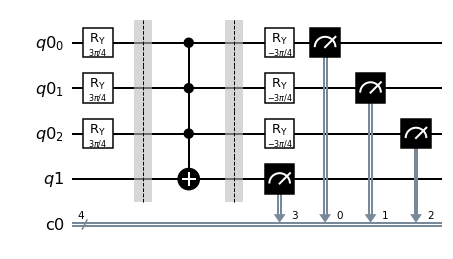

In [2]:
Asqr = 1/2
A = np.sqrt(Asqr)
theta = np.arcsin(A)*2
n=3

q = QuantumRegister(n)
anc = QuantumRegister(1)
c = ClassicalRegister(n+1)
qc = QuantumCircuit(q,anc, c)

theta = 3*pi/4
qc.ry(theta,q)
qc.barrier()
qc.mct(q[0:n],anc[0],mode='noancilla') 
qc.barrier()
qc.ry(-theta,q)
qc.measure(q[0:n], c[0:n])
qc.measure(anc,c[n:n+1])
qc.draw(output = 'mpl',style='bw')

## Measurement
- The $1^{st}$ nonlocal condition will show that there is no $|111...\rangle$ state when measuring all qubits in the $|u\rangle,|v\rangle$ basis.
- The $2^{nd}$ nonlocal conditions will show that if the $k^{th}$ qubit is measured at `1` in the $|c\rangle,|d\rangle$ basis, then all others qubits in $|u\rangle,|v\rangle$ basis will also `1`. 
- The $3^{rd}$ nonlocal conditions will show a non-zero probability of measuring 2 `1` or more in $|c\rangle,|d\rangle$ basis, which should constitute a paradox for local-hidden-variable (LHV) theory.

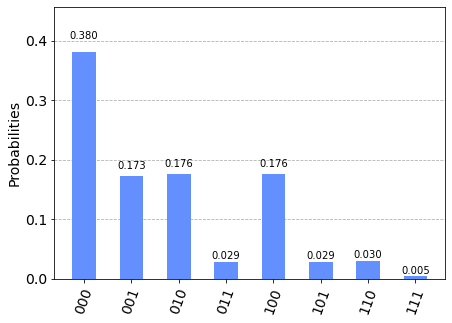

In [3]:
shots = 100000
job = execute(qc, backend=simulator, shots=shots)
counts = job.result().get_counts(qc)
explode = 0
for k, v in list(counts.items()):
    i=0
    for p in range(1):
        if (k[i] == '1'):
            explode = explode + v
            del counts[k]
            break
        i+=1

for k,v in list(counts.items()):
    counts[k[1:]]=counts.pop(k)
plot_histogram(counts)

## 2.2. Unitary evolution simulation

Instead of using postselection, we can also prepare $|\Psi_n\rangle$ and initialize it on the quantum circuit. The same rule is used to test nonlocal conditions.

In [4]:
n=3
u = np.ones(2**n,dtype='int8')        
u[-1] = 0

#first set of qc.ry(theta,q)
theta = 0.75*pi #theta angle
rot = np.array([cos(theta/2),sin(theta/2)])
rotation = rot
for i in range(n-1):
    rotation = np.reshape(np.outer(rotation,rot), -1)

v = u*rotation
v = normalize(v.reshape(-1, 1),axis=0).T[0]
sv = quantum_info.Statevector(v) #|Psi_n>

In [5]:
#initialize circuits according to prepared vector
qc = QuantumCircuit(n)
qc.initialize(sv.data, range(n))
qc.ry(-theta,range(n)) #pick the qubits to test the nonlocal conditions
qc.measure_all()
qc.draw()

»
   q_0: »
        »
   q_1: »
        »
   q_2: »
        »
meas: 3/»
        »
«        ┌─────────────────────────────────────────────────────────────────────────┐»
«   q_0: ┤0                                                                        ├»
«        │                                                                         │»
«   q_1: ┤1 Initialize(0.091136,0.22002,0.22002,0.53118,0.22002,0.53118,0.53118,0) ├»
«        │                                                                         │»
«   q_2: ┤2                                                                        ├»
«        └─────────────────────────────────────────────────────────────────────────┘»
«meas: 3/═══════════════════════════════════════════════════════════════════════════»
«                                                                                   »
«        ┌───────────┐ ░ ┌─┐      
«   q_0: ┤ Ry(-3π/4) ├─░─┤M├──────
«        ├───────────┤ ░ └╥┘┌─┐   
«   q_1: ┤ Ry(-3π/4) ├─░──╫─┤M├───
«        ├───────────┤ ░  ║ └╥┘┌─┐
«   q_2: ┤ Ry(-3π/4) ├─░──╫──╫─┤M├
«        └───────────┘ ░  ║  ║ └╥┘
«meas: 3/═════════════════╩══╩══╩═
«                         0  1  2

In [6]:
#transpilation of gates used
qc=transpile(qc,basis_gates=["u1","u2","u3","cx"],optimization_level=1)
qc.draw()

┌───────────────┐                              ┌───┐┌───────────────┐»
   q_0: ┤ U3(9π/16,0,0) ├──────────────────────────────┤ X ├┤ U3(3π/16,0,0) ├»
        ├───────────────┴┐┌───┐┌─────────────────┐┌───┐└─┬─┘└───────────────┘»
   q_1: ┤ U3(1.9239,0,0) ├┤ X ├┤ U3(0.43224,0,0) ├┤ X ├──■───────────────────»
        ├────────────────┤└─┬─┘└─────────────────┘└─┬─┘                      »
   q_2: ┤ U3(1.7982,0,0) ├──■───────────────────────■────────────────────────»
        └────────────────┘                                                   »
meas: 3/═════════════════════════════════════════════════════════════════════»
                                                                             »
«        ┌───┐┌─────────────────┐┌───┐┌───────────────┐ ┌───┐┌────────────────┐»
«   q_0: ┤ X ├┤ U3(3π/16,-π,-π) ├┤ X ├┤ U3(3π/16,0,0) ├─┤ X ├┤ U3(3π/4,-π,-π) ├»
«        └─┬─┘└─────────────────┘└─┬─┘├───────────────┴┐└─┬─┘└────────────────┘»
«   q_1: ──┼───────────────────────■──┤ U3(3π/4,-π,-π) ├──┼────────────────────»
«          │                          └────────────────┘  │  ┌────────────────┐»
«   q_2: ──■──────────────────────────────────────────────■──┤ U3(3π/4,-π,-π) ├»
«                                                            └────────────────┘»
«meas: 3/══════════════════════════════════════════════════════════════════════»
«                                                                              »
«         ░ ┌─┐      
«   q_0: ─░─┤M├──────
«         ░ └╥┘┌─┐   
«   q_1: ─░──╫─┤M├───
«         ░  ║ └╥┘┌─┐
«   q_2: ─░──╫──╫─┤M├
«         ░  ║  ║ └╥┘
«meas: 3/════╩══╩══╩═
«            0  1  2

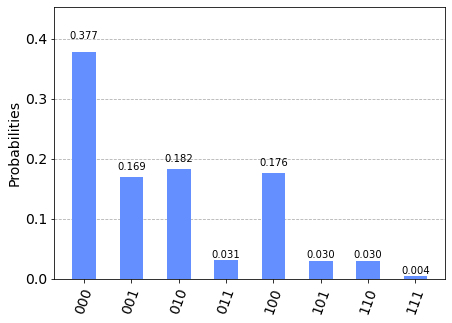

In [7]:
#Measurement
shots = 10000
job = execute(qc, backend=simulator, shots=shots)
counts = job.result().get_counts(qc)
plot_histogram(counts)

# 2. Nonlocal probability

## 2.1. Theory

Plotting $	P_\text{nonlocal}=A^{2n}-n\frac{A^{4n-2}(1-A^{2})}{1-A^{2n}}. $

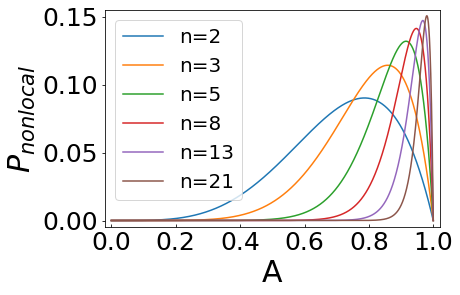

In [8]:
np.seterr(divide='ignore', invalid='ignore') #ignore divide by zero warning

fig = plt.figure(figsize=(6,4))
ax = plt.subplot(111)
x=np.linspace(0,1,10**6+1)

for n in [2,3,5,8,13,21]:    
    y0 = (x**(2*n))+n*x**(4*n-2)*(x**2-1)/(1-x**(2*n))
    plt.plot(x,y0,label='n=%s'%n)

plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True, direction="in", labelsize=25) 
plt.tick_params(axis="y", labelsize=25)

plt.xlabel('A',size=30)
plt.ylabel('$P_{nonlocal}$',size=30)
plt.legend(loc = 'upper left',fontsize=20)
plt.yticks([0,0.05,0.1,0.15])
plt.xticks([0,0.2,0.4,0.6,0.8,1])
plt.xlim(-0.02, 1.02)
plt.ylim(bottom=-0.005, top = 0.155)
plt.show()

Calculate optimal $P_{nonlocal}$ for large $n$

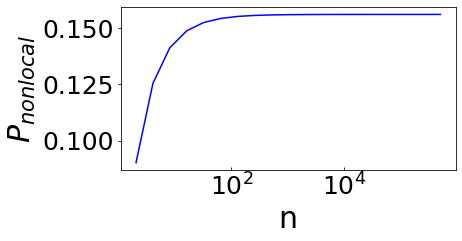

In [9]:
np.seterr(divide='ignore', invalid='ignore') #ignore divide by zero warning
plist = []
nlist = []
fig = plt.figure(figsize=(6,3))
ax = plt.subplot(111)

for i in range(1,20):
    n = 2**i
    nlist.append(n)
    x=np.linspace(0,1,2**(i+4)+1)
    y=(x**(n))+n*x**(2*n-1)*(x-1)/(1-x**(n))
    maxy0 = max(y) #find maximal nonlocal probability for each n
    
    plist.append(maxy0)
plt.plot(nlist, plist, color = 'blue')
plt.xscale('log')
plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True, direction="in", labelsize=25) 
plt.tick_params(axis="y", labelsize=25)

plt.xlabel('n',size=30)
plt.ylabel('$P_{nonlocal}$',size=30)
plt.show()

## 2.2. Post-selection simulation
Comparision with theoretical formula above shows similar results.

Circuits that were used:

In [10]:
#Results without simulation (to save time)
nondict = {2: [0, 0.012033484124291834, 0.05649553032405997, 0.08634461825497936, 0.08787820210183529, 0.07443688547066582, 0.05597152419265996, 0.04056944334423484, 0.026848328697937105, 0.018722424211057485, 0], 3: [0, 0.001881565566748989, 0.029423541953768947, 0.0796962874341752, 0.11056291202835439, 0.1118816611254389, 0.0932740114686518, 0.07203150274039291, 0.05174386030441685, 0.03543869176396395, 0], 4: [0, 0.00022705562862901417, 0.011762393571107267, 0.05536615078598153, 0.10426330341094822, 0.12449756340483051, 0.11687965688629555, 0.09477866236626908, 0.07205707920099944, 0.05047797791039941, 0], 5: [0, 3.3000957027753814e-05, 0.004246438033943383, 0.034139414442634596, 0.0870224612597684, 0.1255736087225602, 0.13071162308989415, 0.11375887039692192, 0.08819615336004821, 0.0649558285087552, 0], 6: [0, 7.000028000112001e-06, 0.0014941321265445784, 0.019723631840541562, 0.06790039219602034, 0.11680576006193163, 0.13625041804559315, 0.12617536833845194, 0.10228006366536055, 0.07653061224489803, 0], 7: [0, 1e-06, 0.0005062622438423102, 0.011145393038531248, 0.051177612447438084, 0.10528644837358908, 0.13529070572886145, 0.13420818082786468, 0.11449348368740833, 0.08876047855456988, 0], 8: [0, 0, 0.0001800289846665315, 0.006020592580069955, 0.03694371484338578, 0.09150842771532429, 0.13175677590888732, 0.13980477943617678, 0.12348310838279529, 0.0973901074022424, 0], 9: [0, 0, 4.600280617117648e-05, 0.0033624356436239714, 0.026554043175090723, 0.07778057512127991, 0.12603875708828424, 0.14278060770378925, 0.13151197240118517, 0.1063933225370945, 0], 10: [0, 0, 2.5000575013225316e-05, 0.0017891363560321124, 0.018885561831672684, 0.065048209707005, 0.11721143861432862, 0.14334520805898682, 0.13760866950724937, 0.11413663441632503, 0], 11: [0, 0, 7.000028000112001e-06, 0.0009208895793336477, 0.013114890499542906, 0.05454680395870829, 0.10870609570451512, 0.14158166169971248, 0.14159071746898547, 0.12156131855358149, 0], 12: [0, 0, 1.000001000001e-06, 0.0004922490780334794, 0.009159135048007172, 0.0445933713414523, 0.09948072691091671, 0.1391479371284954, 0.14595989646299193, 0.12819175703405392, 0], 13: [0, 0, 2.000002000002e-06, 0.0002970822917948267, 0.006411275953638012, 0.036623480029967945, 0.09063244474586085, 0.13513784224064024, 0.146275180812973, 0.13253407784529656, 0], 14: [0, 0, 0, 0.00013902071408639877, 0.004364671574787524, 0.02967544680957211, 0.08162742540041651, 0.12983664556341326, 0.14807006968264858, 0.13703481921950605, 0], 15: [0, 0, 0, 7.30059134789918e-05, 0.002910070690341786, 0.023944404426353105, 0.07302004432536352, 0.12373766278361294, 0.1483005584278527, 0.14095189379992304, 0], 16: [0, 0, 0, 4.000164006724277e-05, 0.002041172155886599, 0.01934121354109599, 0.06491736913128551, 0.11811066495972146, 0.14666563304877672, 0.1432386786812028, 0]}

D:\Temp\ipykernel_7656\2269725100.py:7: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


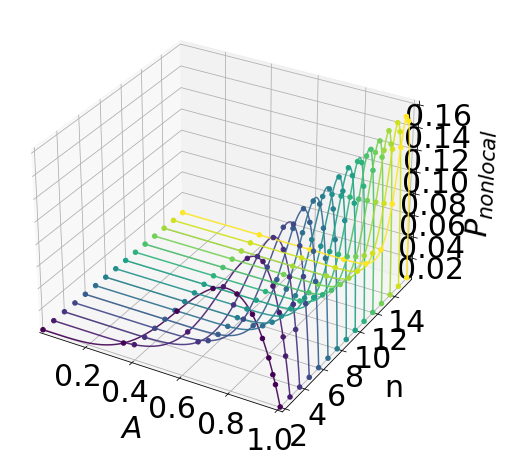

In [11]:
%matplotlib inline
import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)

np.seterr(divide='ignore', invalid='ignore') #ignore divide by zero warning

cmap = mpl.cm.get_cmap('viridis')
color_gradients = cmap(np.linspace(0,1,15)) 

for n in range(2,17):

    #-----------this run simulation result--------------------
    Asim= 1-np.flip(np.geomspace(10**-((1.7)), 1, num=10,endpoint=True))
    Asim =  np.append(Asim,np.float64(1))
    theta = np.arccos(Asim)*2
    y1 = nondict[n]
    
    #-----------this run theory-----------
    Afull = np.linspace(0,1,10**4)
    x=Afull
    y2 = (x**(2*n))+n*x**(4*n-2)*(x**2-1)/(1-x**(2*n))
    
    ax.plot(Afull, np.full((len(Afull),1), n), y2,color = color_gradients[n-2],linestyle='solid',alpha=0.9)
    ax.scatter(Asim, np.full((len(Asim),1), n), y1,color = color_gradients[n-2],marker='o', alpha=1)

ax.set_xlabel('$A$',fontsize = '30',labelpad=20)
ax.set_ylabel('n',fontsize = '30',labelpad=20)
ax.set_zlabel('$P_{nonlocal}$',fontsize = '30',labelpad=20)
#change fontsize
for t in ax.xaxis.get_major_ticks(): t.label.set_fontsize(30)
for t in ax.yaxis.get_major_ticks(): t.label.set_fontsize(30)
for t in ax.zaxis.get_major_ticks(): t.label.set_fontsize(30)
ax.zaxis._axinfo['label']['space_factor']=0
ax.view_init(30, 300)
ax.set_xlim(xmin=0.02,xmax=1)
ax.set_ylim(2,(16-0.3))
ax.set_zlim(zmin = 0.003,zmax=0.16)

plt.show()

## 2.3. Experiments on IBM Quito

### Circuits
Circuits that were used:

## data and figures 
(prepared to save time)

In [12]:
backend = 'ibmq_quito'
split = 8
A_exp = np.linspace(0.25,0.95,split)
tlist = np.arcsin(A_exp)*2
#calculate nonlocal probability from accumulated data
n=3
j=0
nonlist_m = np.zeros(split)
for t in tlist:
    countssim3 = np.load(os.path.join('data','Toff_count_%s_%s_%s_m'%(n,backend,j)),allow_pickle='True')
    
    for k, v in list(countssim3.items()):
        i=0
        for p in range(1):
            if (k[i] == '1'):
                del countssim3[k]
                break
            i+=1

    for k,v in list(countssim3.items()):
        countssim3[k[1:]]=countssim3.pop(k)
    d = countssim3
    d1 = { k: d[k]/sum(d[k] for k in d) for k in d }
    nonloc = sum(v for k, v in d1.items() if (k.count('0') > 1) )
    nonlist_m[j]+=nonloc
    j+=1
#calculate std for each 100 runs of 20000 shots of each theta from raw data
n=3
nonlist_mforvar = []
j=0
for t in tlist:
    nonlist_mforvar.append([])
    j+=1
    
countlist = {}
j=0
for t in tlist:
    countlist[j] = np.load(os.path.join('data','Toff_raw_%s_%s_%s'%(n,backend,j)),allow_pickle='True')
    for l in range(100):
        countssim3=countlist[j][l]
        for k, v in list(countssim3.items()):
            i=0
            for p in range(1):
                if (k[i] == '1'):
                    del countssim3[k]
                    break
                i+=1

        for k,v in list(countssim3.items()):
            countssim3[k[1:]]=countssim3.pop(k)
        d = countssim3
        d1 = { k: d[k]/sum(d[k] for k in d) for k in d }
        nonloc = sum(v for k, v in d1.items() if (k.count('0') > 1) )
        nonlist_mforvar[j].append(nonloc)
    j+=1
std = np.std(nonlist_mforvar,1)

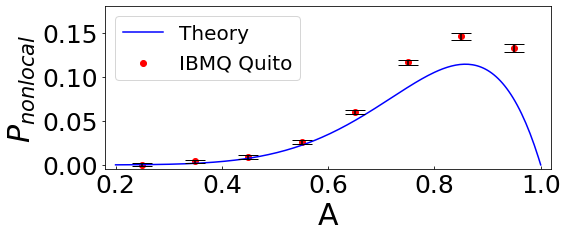

In [13]:
shift = 0.019902 #systematic error shift
n=3
split = 8
fig = plt.figure(figsize=(8,3))
ax = plt.subplot(111)
A_exp = np.linspace(0.25,0.95,split)
A_theo = np.linspace(0.2,1+0.0000001,201)
x = A_theo
y = (x**(2*n))-n*x**(4*n-2)*(1-x**2)/(1-x**(2*n))
plt.plot(A_theo,y,label='Theory',color='blue')
plt.scatter(A_exp,nonlist_m-shift,label='IBMQ Quito',color='r')
plt.errorbar(A_exp,nonlist_m-shift, yerr=std,color='k',capsize = 10,linestyle='')

plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True, direction="in", labelsize=25) 
plt.tick_params(axis="y", labelsize=25)

plt.xlabel('A',size=30)
plt.ylabel('$P_{nonlocal}$',size=30)
plt.legend(loc = 'upper left',fontsize=20)
plt.yticks([0,0.05,0.1,0.15])
plt.xticks([0.2,0.4,0.6,0.8,1])
plt.xlim(0.18, 1.02)
plt.ylim(bottom=-0.005, top = 0.18)
plt.show()

# 3. von Neumannn entropy

## at optimal A

Prepare circuits at optimal A, and measure von Neumann entropy at half-chain

In [14]:
np.seterr(divide='ignore', invalid='ignore') #ignore divide by zero warning
#find where maximal nonlocality is
plist = [] #maximal nonlocal probability
tlist = [] #theta of maximal nonlocal probability
Alist = [] #A of maximal nonlocal probability

nmax = 14
nlist = range(2,nmax+1)
for n in nlist:
    x=np.linspace(0,1,10**6+1)
    y=(x**(n))+n*x**(2*n-1)*(x-1)/(1-x**(n))
    maxy0 = max(y) #find where maximal nonlocality is
    Asquare0=x[np.nanargmax(y)]
    A0=np.sqrt(Asquare0)
    theta0 = np.arcsin(A0)*2/pi
    plist.append(maxy0)
    Alist.append(A0)
    tlist.append(theta0)

print('Optimal theta list for |Psi>')
print(tlist)

Optimal theta list for |Psi>
[0.5758588115146593, 0.6568939778537597, 0.7041696062091627, 0.7360816646095719, 0.7594840107086392, 0.7775914272865768, 0.7921401553078653, 0.8041624998462139, 0.8143138819161249, 0.823034737769241, 0.8306313571224886, 0.8373267951477363, 0.8432852100532339]


In [15]:
vne = []

for (t,n) in zip(tlist,nlist):
    start = time.time()
    anc = QuantumRegister(1)
    q = QuantumRegister(n)
    c = ClassicalRegister(1+n)
    qc = QuantumCircuit(q, anc,c)

    theta = t*pi
    qc.ry(theta,q)
    qc.mct(q[0:n],anc[0],mode='noancilla')

    backend = Aer.get_backend('statevector_simulator')
    job = execute(qc, backend)
    result = job.result()
    outputstate = result.get_statevector(qc)
    keep_length = 2**n
    del_length = 2**(n+1)-keep_length
    partialstate = np.delete(outputstate,np.arange(del_length)+keep_length)
    normed_tensor = (partialstate/np.linalg.norm(partialstate))
    partialtraceA =  get_subsystem_density_matrix(normed_tensor,range(n//2))

    #------VNE------ 
    en=quantum_info.entropy(partialtraceA)
    vne.append(en) #VNE qiskit
    end = time.time()
    print(n,'vne =',en, 'time =',end-start)

2 vne = 0.6742490161589455 time = 0.017980098724365234
3 vne = 0.6315148728355149 time = 0.013957023620605469
4 vne = 0.6947204667340705 time = 0.015624046325683594
5 vne = 0.6778876290820114 time = 0.009473085403442383
6 vne = 0.7007500357476556 time = 0.022381067276000977
7 vne = 0.6919302242450396 time = 0.03140425682067871
8 vne = 0.7036367276075135 time = 0.028327465057373047
9 vne = 0.6982305344877938 time = 0.03775954246520996
10 vne = 0.705330994952345 time = 0.056200504302978516
11 vne = 0.7016850673302065 time = 0.12628889083862305
12 vne = 0.7064464196035867 time = 0.45117950439453125
13 vne = 0.7038211605187149 time = 1.316974401473999
14 vne = 0.7072316648628537 time = 5.202866315841675


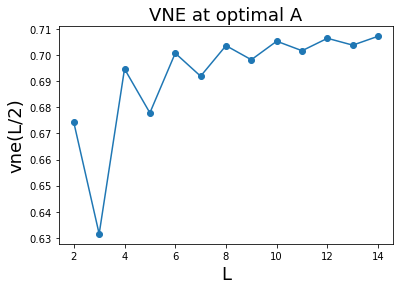

In [16]:
plt.plot(nlist,vne,marker='o')
plt.title('VNE at optimal A',fontsize = 18)
plt.xlabel('L',fontsize = 18)
plt.ylabel('vne(L/2)',fontsize = 18)
plt.show()

## at changing A

Prepare circuits at A change from 0 to 1, and measure von Neumann entropy at half-chain

In [17]:
vne = {}

for n in [2,5,11]:
    start = time.time()
#--------this part is to calculate von Neumann entropy to theta angles

    A = np.linspace(0,1-(10**-9),10**2)
    theta = np.arcsin(A)*2
    vne[n] = []

    for t in theta:
        anc = QuantumRegister(1)
        q = QuantumRegister(n)
        c = ClassicalRegister(1+n)
        qc = QuantumCircuit(q, anc,c)

        qc.ry(t,q)
        qc.mct(q[0:n],anc[0],mode='noancilla') 

        backend = Aer.get_backend('statevector_simulator')
        job = execute(qc, backend)
        result = job.result()
        outputstate = result.get_statevector(qc)
        keep_length = 2**n
        del_length = 2**(n+1)-keep_length
        partialstate = np.delete(outputstate,np.arange(del_length)+keep_length)
        normed_tensor = (partialstate/np.linalg.norm(partialstate))
        partialtraceA =  get_subsystem_density_matrix(normed_tensor,range(n//2))
        vne[n].append(quantum_info.entropy(partialtraceA))

end = time.time()
print(end-start)

13.681931495666504


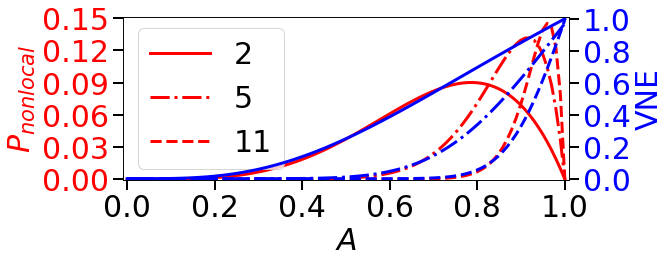

In [18]:
clist = ['red','green','blue','orange','black']
lslist = ['solid','dashdot','dashed','dotted', (0, (3, 1, 1, 1, 1, 1)), (0, (1, 1))]
lwlist = [2,2,3]
fig, ax1 = plt.subplots(figsize=(8,3))
plt.yticks(np.linspace(0.,0.15,6))
ax2 = ax1.twinx()

nonloc = {}
i=0

for n in [2,5,11]:
    x=A
    nonloc[n] = list((x**(2*n))+n*x**(4*n-2)*(x**2-1)/(1-x**(2*n)))
    ax1.set_xscale('linear')
    ax2.set_xscale('linear')
    ax1.plot(x, nonloc[n], linestyle = lslist[i], color = 'r', label = '%s'%(n),linewidth=3)
    ax2.plot(A, vne[n], linestyle = lslist[i],color = 'b', label = '%s'%(n),linewidth=3)
    i+=1

ax1.tick_params(axis='both', which='major', labelsize=30)
ax1.tick_params(axis='both', which='minor', labelsize=30)
ax1.tick_params(axis='y',width=2,length=10)
ax1.tick_params(axis='x',width=2,length=10)
for i in range(6):
    ax1.get_yticklabels()[i].set_color('red')
ax1.set_ylim(ymin=-0.001,ymax=0.151)
ax1.set_xlim(xmin=-0.01,xmax=1.01)
ax2.tick_params(axis='both', which='major', labelsize=30)
ax2.tick_params(axis='both', which='minor', labelsize=30)
ax2.tick_params(axis='y',width=2,length=10)
for i in range(4):
    ax2.get_yticklabels()[i].set_color('blue')
ax2.set_ylim(ymin=-0.01,ymax=1.01)
ax1.set_xlabel('$A$',fontsize = '30')
ax1.set_ylabel('$P_{nonlocal}}$', color='r',fontsize = '30')
ax2.set_ylabel('VNE', color='b',fontsize = '30')
ax1.legend(fontsize='30',loc='center left')
plt.yticks(np.linspace(0,1,6))
plt.xticks(np.linspace(0,1,6))

plt.show()

## at constant A

Prepare circuits at constant A, and measure von Neumann entropy at half-chain

In [19]:
vne = []
nmax = 14
nlist = range(2,nmax+1)
const_theta = 0.7
tlist = [const_theta]*(nmax-1)

for (t,n) in zip(tlist,nlist):
    start = time.time()
    anc = QuantumRegister(1)
    q = QuantumRegister(n)
    c = ClassicalRegister(1+n)
    qc = QuantumCircuit(q, anc,c)

    theta = t*pi
    qc.ry(theta,q)
    qc.mct(q[0:n],anc[0],mode='noancilla') 

    backend = Aer.get_backend('statevector_simulator')
    job = execute(qc, backend)
    result = job.result()
    outputstate = result.get_statevector(qc)
    keep_length = 2**n
    del_length = 2**(n+1)-keep_length
    partialstate = np.delete(outputstate,np.arange(del_length)+keep_length)
    normed_tensor = (partialstate/np.linalg.norm(partialstate))
    partialtraceA =  get_subsystem_density_matrix(normed_tensor,range(n//2))

    #------VNE------ 
    en=quantum_info.entropy(partialtraceA)
    vne.append(en) #VNE qiskit
    end = time.time()
    print(n,'vne =',en, 'time =',end-start)

2 vne = 0.8375713180271684 time = 0.016875028610229492
3 vne = 0.697561342186342 time = 0.01698136329650879
4 vne = 0.6864288376140099 time = 0.014960050582885742
5 vne = 0.5983147825711566 time = 0.009761810302734375
6 vne = 0.550448569322247 time = 0.015679597854614258
7 vne = 0.4817760680325189 time = 0.0321199893951416
8 vne = 0.4320931962264694 time = 0.031246423721313477
9 vne = 0.37656420285792025 time = 0.02081131935119629
10 vne = 0.33231064104143104 time = 0.06710958480834961
11 vne = 0.28765721651469867 time = 0.1330106258392334
12 vne = 0.25068362535330846 time = 0.4355754852294922
13 vne = 0.21540528238021706 time = 1.3380546569824219
14 vne = 0.18575254155741294 time = 5.142827749252319


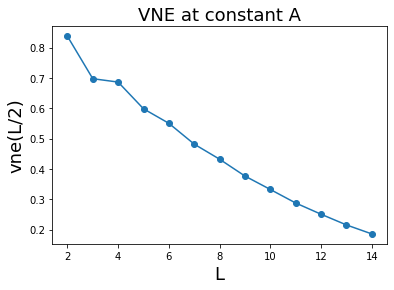

In [20]:
plt.plot(nlist,vne,marker='o')
plt.title('VNE at constant A',fontsize = 18)
plt.xlabel('L',fontsize = 18)
plt.ylabel('vne(L/2)',fontsize = 18)
plt.show()